In [1]:
import heeps
import heeps.wavefront.qacits_vlt_package_v4 as qacits
from heeps.util.coord import disk_coord, mas2rms, rms2mas
from heeps.contrast.background import background
from photutils import CircularAperture, aperture_photometry
import numpy as np
import astropy.units as u
from astropy.io import fits
import os
from copy import deepcopy
import matplotlib.pyplot as plt
%matplotlib inline

# Input parameters

dits = [0.3 0.6 1.2 2.4 4.8]
calib drift = 120 points in each direction


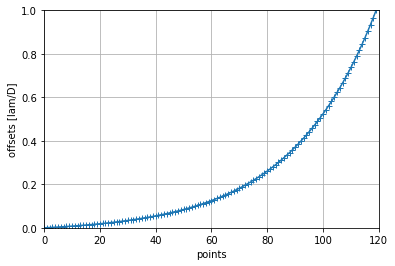

In [2]:
f_lyot_stop = 'ls_%s_%s_%s_%s_%s_%s.fits'
f_lyot_stop_mis = 'ls_%s_%s_%s_%s_%s_%s_mis_%s_%s.fits'
f_phase = 'wavefront/cfull/cube_Cfull_20211007_3600s_100ms_0piston_meters_scao_only_%s_%s.fits'
f_point_err = 'wavefront/point/point_all_3600s_100ms_%s.fits'
cases = ['linear_drift_only', 'scao+linear_drift', 'scao+random_drift', 'scao_only']
targets = ['point', 'alphaCen', 'pi1Gru']
# mags range
rmags = {'L': np.arange(6, 12+1),
        'N2': np.arange(0, 6+1)}
# define DITs (detector integration times) via downsample ratios
down_rats = np.array([1, 2, 4, 8, 16])*3
dit0 = 0.1 # time per frame
dits = dit0*down_rats
print('dits = %s'%dits)
# up to 0.1 lam/D, step = 1/100
# up to 1 lam/D, step = 1/10
#xy = np.append(np.arange(100)/1000, np.arange(1,11)/10)
#xy = np.arange(110)/109
logb = .02
npts = 120
xy = np.logspace(np.log10(logb), np.log10(1 + logb), npts) - logb
print('calib drift = %s points in each direction'%len(xy))
plt.plot(xy,'-+')
plt.xlim(0, len(xy))
plt.ylim(0, 1)
plt.xlabel('points')
plt.ylabel('offsets [lam/D]')
plt.grid(True), plt.grid(which='minor', linestyle=':')
# dictionary with default qacits parameters
default_params = dict(
    radii = {'inner': (0, 1.7), 'outer': (1.7, 2.3), 'full': (0, 2.7)},
    inner_slope = 1,#0.149,
    outer_slope = 1,#0.063,
    full_coeff = 1,#2,
    ratio = 0,
    phase_tolerance = 60,
    modul_tolerance = 0.33,
    small_tt_regime = 0.3,
    large_tt_regime = 0.2,
)
# qacits: number of averaged frames
n_bin           = 0 # if 0: no averaging, every estimates are returned in a 2D array
                    # if 1: average all frames before computing the estimate
                    # if n_bin=integer < n_img: will return as many estimates (frames are 
                    # averaged by bins of n_img/n_bin before computing the estimates).
force = 'outer'# None# 

In [3]:
rstar_catalog = {'alphaCen': 4.26, # mas
                 'pi1Gru': 9.18, # mas
                 }
def get_fp_offsets(target, diam_ext=36.905, nr=4, disp=True):
    if target in rstar_catalog:
        rstar = rstar_catalog[target]
        fp_offsets_mas = disk_coord(rstar, nr=nr)
        fp_offsets = mas2rms(fp_offsets_mas, diam_ext)
    else:
        fp_offsets = None
    # scatter plot
    if fp_offsets is not None and disp is True:
        print('noffsets = %s'%len(fp_offsets))
        plt.scatter(fp_offsets_mas[:,0], fp_offsets_mas[:,1])
        circ = plt.Circle((0,0), rstar, linestyle=':', color='k', fill=False)
        ax = plt.gca()
        ax.add_artist(circ)
        ax.axis('equal')
        plt.xlabel('x [mas]')
        plt.ylabel('y [mas]')
        plt.title('R = %s mas (%s) - %s pts'%(rstar, target, len(fp_offsets)))
    return fp_offsets

def get_lamD(conf): # in mas per lambda/D
    diamLS = conf['diam_ext'] - conf['diam_nominal']*conf['ls_dRext']
    lamD = conf['lam']/diamLS*u.rad.to('mas')
    return lamD

def get_fwhm(conf): # in pixels
    fwhm = get_lamD(conf)/conf['pscale']
    return fwhm

def get_psf_flux(conf, psf, verbose=False): # photutils aperture photometry
    fwhm = get_fwhm(conf) 
    nimg = psf.shape[-1]
    aper = CircularAperture((nimg//2, nimg//2), r=fwhm/2)
    psf_flux = aperture_photometry(psf, aper)['aperture_sum'].data
    if verbose is True:
        print('photutils aperture photometry: psf_flux=%s'%np.round(psf_flux,5))
    return psf_flux

def downsample_arr(arr, downsample_ratio=1):
    new_arr = np.array(arr).reshape(-1, downsample_ratio, *arr.shape[1:]).mean(axis = 1)
    return new_arr

def circ_drift(radii, npts=12):
    x, y = [], []
    for r in radii:
        xi, yi = [], []
        for t in np.arange(npts)*2*np.pi/npts:
            z = r*np.exp(1j*t)
            xi.append(np.real(z))
            yi.append(np.imag(z))
            x.append(np.real(z))
            y.append(np.imag(z))            
        plt.scatter(xi, yi, label='r = %s mas'%r)
        circ = plt.Circle((0,0), r, linestyle=':', color='k', fill=False)
        ax = plt.gca()
        ax.add_artist(circ)
    ax.axis('equal')
    ax.grid(True)
    plt.legend()
    plt.xlabel('x [mas]')
    plt.ylabel('y [mas]')
    xy_rms = mas2rms(np.vstack((x,y)), conf['diam_ext']) # converted to rms
    return xy_rms.T

def create_psfs(band, mode, ls_params, pupil_shape, case, target='', 
        radii=[1.6, .8, .4], astigmatism=0, ls_misalign=None, verbose=False):
    # update case name
    if 'circ_drift' in case:
        case += '_' + str(radii)
    if ls_misalign is not None:
        case += '_misalign_' + str(ls_misalign)
    if astigmatism != 0:
        case += '_astigmatism_%.2e'%astigmatism
    # initialize conf
    dir_output = os.path.join('qacits_%s/%s_%s'%(pupil_shape, band, mode), 
            target, case)
    conf = dict(dir_output=dir_output, band=band, mode=mode, nframes=2*len(xy),
        dit=dit0, astigmatism=astigmatism, add_phase=True, add_point_err=True)
    if pupil_shape == 'circ':
        conf.update(f_pupil='', spi_width=0, seg_width=0, seg_gap=0)
    else:
        conf.update(f_pupil='pupil/ELT_fullM1.fits')
    conf = heeps.config.read_config(verbose=False, **conf)
    conf = heeps.config.update_config(saveconf=True, verbose=False, **conf)
    conf['f_phase'] = os.path.join(conf['dir_input'], 
            f_phase%(band, conf['npupil']))
    conf['f_point_err'] = os.path.join(conf['dir_input'], f_point_err%band)
    if ls_misalign is None:
        conf['f_lyot_stop'] = os.path.join(conf['dir_input'], 'pupil', pupil_shape, 
            f_lyot_stop%(band, mode, *ls_params, conf['npupil']))
    else:
        conf['f_lyot_stop'] = os.path.join(conf['dir_input'], 'pupil', pupil_shape, 
            f_lyot_stop_mis%(band, mode, *ls_params, conf['npupil'], *ls_misalign))        
    conf['ls_dRext'] = ls_params[0]
    conf['fp_offsets'] = get_fp_offsets(target)
    # load errors
    phase_screens, amp_screens, tiptilts, apo_misaligns, ls_misaligns \
            = heeps.wavefront.load_errors(verbose=verbose, **conf)
    # linear tiptilt
    lamD = get_lamD(conf)
    xy_rms = mas2rms(xy*lamD, conf['diam_ext']) # converted to mas, then to rms
    tt = np.array([(x,0) for x in xy_rms] + [(0,y) for y in xy_rms])
    # choose case
    print('\nCase = %s'%case)
    if 'scao_only' in case:
        tiptilts = np.array([None]*conf['nframes'])
    elif 'scao+linear_drift' in case:
        tiptilts = tt
    elif 'scao+random_drift' in case:
        pass
    elif 'circ_drift' in case:
        tiptilts = circ_drift(radii)
        phase_screens = np.array([None]*conf['nframes'])
    else: # calib = linear drift only
        tiptilts = tt
        phase_screens = np.array([None]*conf['nframes'])
    # load PSFs
    try:
        psf = fits.getdata(os.path.join(conf['dir_output'], 
            'offaxis_PSF_%s_%s.fits'%(conf['band'], conf['mode'])))
        psfs = fits.getdata(os.path.join(conf['dir_output'], 
            'onaxis_PSF_%s_%s.fits'%(conf['band'], conf['mode'])))
        print('Loading PSFs')
    except FileNotFoundError:
        # initialize wavefront
        wf = heeps.pupil.pupil(savefits=True, verbose=True, **conf)
        # off-axis PSF
        psf = heeps.wavefront.propagate_one(wf, onaxis=False, savefits=True, 
                verbose=True, **conf)
        # on-axis PSFs
        psfs = heeps.wavefront.propagate_cube(wf, phase_screens=phase_screens,
                amp_screens=amp_screens, tiptilts=tiptilts, apo_misaligns=apo_misaligns, 
                ls_misaligns=ls_misaligns, onaxis=True, savefits=True, verbose=True, **conf)
    # tiptilts in lam/D
    tt_lamD = rms2mas(tiptilts, conf['diam_ext'])/lamD # converted to mas, then to lam/D
    return conf, psf, psfs, tt_lamD

def point_err_rms(qacits_params, img_cube, psf_flux, fwhm, tt_lamD, 
        model_calibration=False, verbose=True):
    # bin + normalize on-axis PSF cube
    img_cube = qacits.bin_images(img_cube, n_bin)
    nimg = img_cube.shape[-1]
    # true tip-tilt amplitude
    calib_tt = np.sqrt(tt_lamD[:,0]**2 + tt_lamD[:,1]**2)
    # tip-tilt estimate
    tiptilt_estimate = qacits.quadrant_tiptilt_v8(qacits_params, img_cube, 
        (nimg//2, nimg//2), psf_flux, fwhm, calib_tt=calib_tt, 
        model_calibration=model_calibration, force=force, exact=True, 
        verbose=verbose)
    # convert to mas
    lamD = get_lamD(conf)
    tt_est = -tiptilt_estimate[:,0:2]*lamD
    tt_true = tt_lamD*lamD
    # distance between estimated and true tt
    dist = np.sqrt((tt_est[:,0]-tt_true[:,0])**2 + (tt_est[:,1]-tt_true[:,1])**2)
    return dist, tt_true, tt_est

def plot_point_err(conf, psf, psfs, tt_lamD, qacits_params=None, nframes=None, show_fig=True):
    # if no qacits_params provided --> calibrate with default params
    if qacits_params == None:
        model_calibration = True
        qacits_params = deepcopy(default_params)
    else:
        model_calibration = False
    # QACITS tip-tilt estimate
    psf_flux = get_psf_flux(conf, psf)
    fwhm = get_fwhm(conf)
    dist, tt_true, tt_est = point_err_rms(qacits_params, psfs[:nframes], 
        psf_flux, fwhm, tt_lamD[:nframes], model_calibration=model_calibration)
    print('rms = %s mas'%round(np.mean(dist), 3))
    if show_fig is True:
        ts = conf['dit']*np.arange(len(tt_lamD))[:nframes]
        fig, (a0, a1, a2) = plt.subplots(3, 1, figsize=(10,6), sharex=True)
        fig.subplots_adjust(hspace=0)
        a0.plot(ts, tt_true[:,0], label='error signal', color='k', linestyle='--')
        a0.plot(ts, tt_est[:,0], label='QACITS estimate')
        a0.set_title('correction at %s band'%conf['band'])
        a0.set_ylabel('x-axis/tilt (mas)')
        a0.legend(loc='upper right'); a0.grid(True)
        a0.set_xlim((0, ts[-1]))
        #a0.set_ylim(bottom=0)
        a1.plot(ts, tt_true[:,1], label='error signal', color='k', linestyle='--')
        a1.plot(ts, tt_est[:,1], label='QACITS estimate')
        a1.set_ylabel('y-axis/tip (mas)')
        a1.legend(loc='upper right'); a1.grid(True)
        a1.set_xlim((0, ts[-1]))
        #a1.set_ylim(bottom=0)
        a2.plot(ts, dist, label='$\mu = %3.2f mas, \sigma = %3.2f mas$'\
                    %(np.mean(dist), np.std(dist)))
        a2.set_xlabel('Duration (s)')
        a2.set_ylabel('Residuals (mas)')
        a2.legend(loc='upper right'); a2.grid(True)
        a2.set_xlim((0, ts[-1]))
        a2.set_ylim(bottom=0)
    return qacits_params, tt_true, tt_est

def rms_mag(qacits_params, conf, psf, psfs, tt_lamD, mags, nframes=None):
    try:
        rms_arr = fits.getdata(os.path.join(conf['dir_output'], 
            'rms_arr_%s_%s.fits'%(conf['band'], conf['mode'])))
        print('Loading RMS array')
    except FileNotFoundError:
        print('mags = %s'%mags)
        fwhm = get_fwhm(conf)
        rms_arr = np.empty((len(dits), len(mags)))
        for i, (conf['dit'], down_rat) in enumerate(zip(dits, down_rats)):
            if i == 0:
                print('DIT = %s s'%round(conf['dit'], 1), end='')
            else:
                print(', %s s'%round(conf['dit'], 1), end='')
            for j, conf['mag'] in enumerate(mags):
                psf_ON, psf_OFF = background(deepcopy(psfs), deepcopy(psf), **conf)
                # integrating DITs
                psf_down = downsample_arr(psf_ON, downsample_ratio=down_rat)
                tt_down = downsample_arr(tt_lamD, downsample_ratio=down_rat)
                psf_flux = get_psf_flux(conf, psf_OFF)
                dist, _, _ = point_err_rms(qacits_params, psf_down[:nframes],
                    psf_flux, fwhm, tt_down[:nframes], model_calibration=False)
                rms_arr[i,j] = np.mean(dist)
        fits.writeto(os.path.join(conf['dir_output'], 
            'rms_arr_%s_%s.fits'%(conf['band'], conf['mode'])), np.float32(rms_arr))
    return rms_arr

def plot_rms_mag(rms_arr, mags, ymax=10):
    plt.figure(figsize=(9, 5))
    for dit, rms in zip(dits, rms_arr):
        plt.plot(mags, rms, label='DIT = %s s'%round(dit, 1))
    plt.legend()
    plt.grid(True), plt.grid(which='minor', linestyle=':')
    plt.yscale('log')
    plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))    
    plt.xlim(min(mags), max(mags))
    plt.ylim(1e-1, ymax)
    plt.xlabel('Star mag')
    plt.ylabel('Pointing error (mas rms)')

def plot_circ_drift(tt_true, tt_est):
    plt.figure()
    plt.scatter(tt_true[:,0], tt_true[:,1], label='tt_true')
    plt.scatter(tt_est[:,0], tt_est[:,1], label='tt_est')
    plt.legend()
    ax = plt.gca()
    ax.axis('equal')
    ax.grid(True)
    plt.xlabel('x [mas]')
    plt.ylabel('y [mas]');

# 1) Circular pupil (L-band CVC)

In [4]:
pupil_shape = 'circ'
band = 'L'
mode = 'CVC'
ls_params = [0.0291, 0.08, 0.0317]

### Calibration: x,y pointing drift -> 1 lambda/D

In [5]:
case = 'calib'


Case = calib
Loading PSFs

Model calibration results:
Inner slope = 0.390
Outer slope = 0.184
Full coeff  = 4.307
rms = 1.0 mas


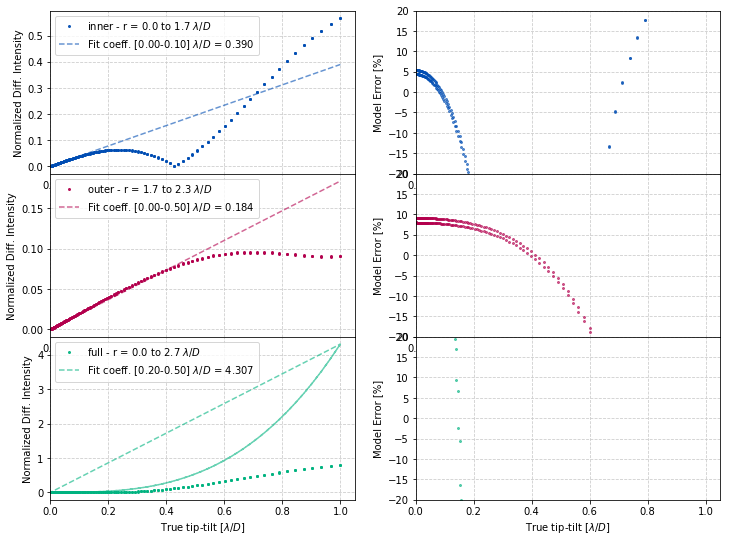

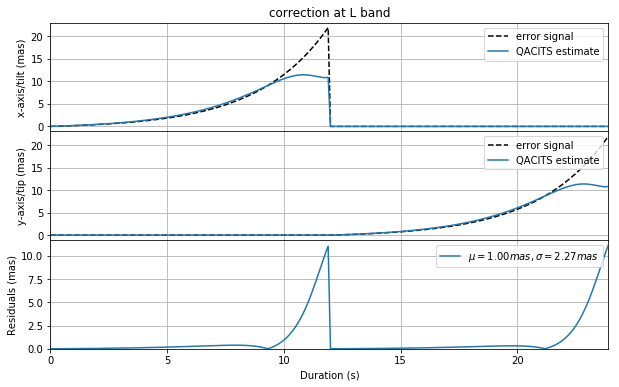

In [6]:
conf, psf, psfs, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case)
circ_params, _, _ = plot_point_err(conf, psf, psfs, tt_lamD)

### Circular drift

In [7]:
case = 'circ_drift'


Case = circ_drift_[1.6, 0.8, 0.4]
Loading PSFs
rms = 0.086 mas


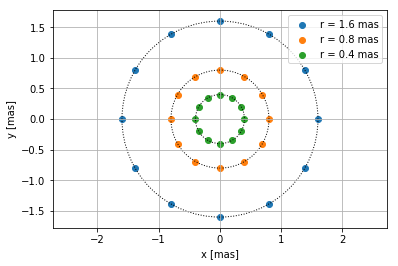

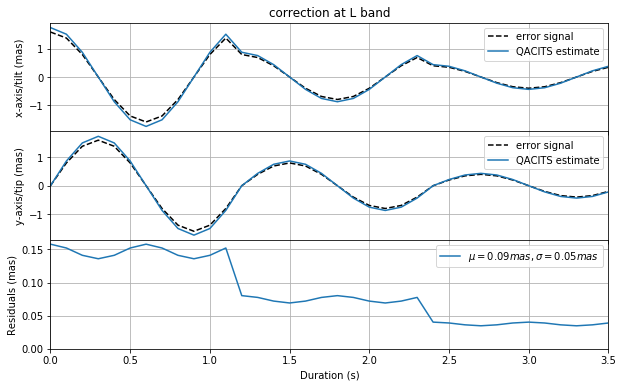

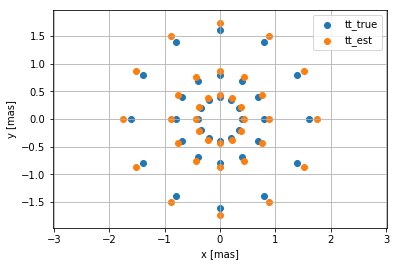

In [8]:
conf, psf, psfs, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case)
_, tt_true, tt_est = plot_point_err(conf, psf, psfs, tt_lamD, qacits_params=circ_params);
plot_circ_drift(tt_true, tt_est)

### X-axis LS misalignment (1%)


Case = circ_drift_[1.6, 0.8, 0.4]_misalign_[1, 0]
Loading PSFs
rms = 0.086 mas


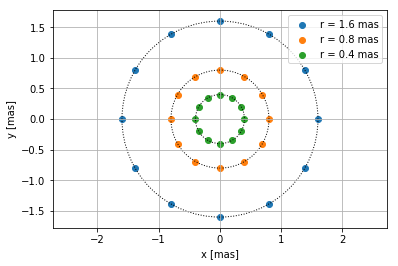

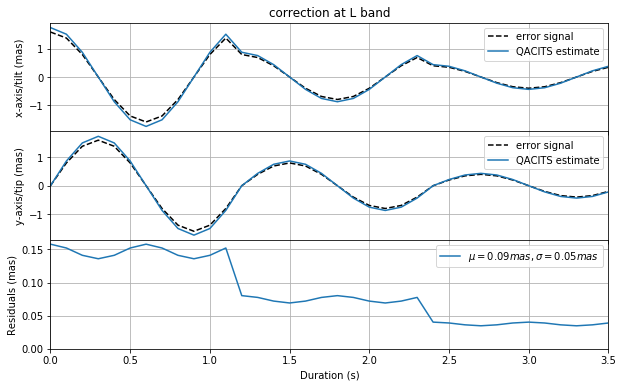

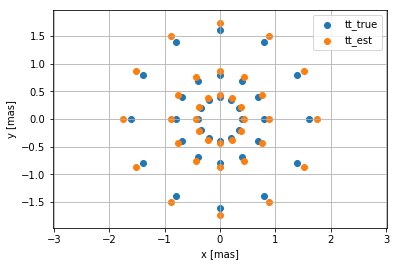

In [9]:
conf, psf, psfs, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case, ls_misalign=[1, 0])
_, tt_true, tt_est = plot_point_err(conf, psf, psfs, tt_lamD, qacits_params=circ_params);
plot_circ_drift(tt_true, tt_est)

### Y-axis LS misalignment (1%)


Case = circ_drift_[1.6, 0.8, 0.4]_misalign_[0, 1]
Loading PSFs
rms = 0.086 mas


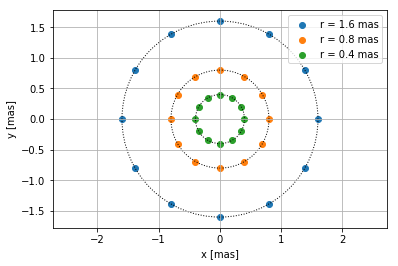

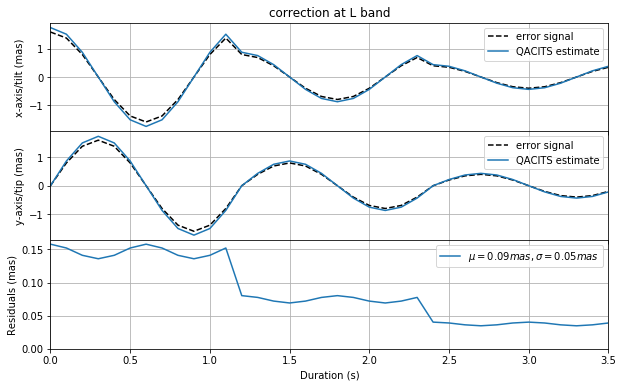

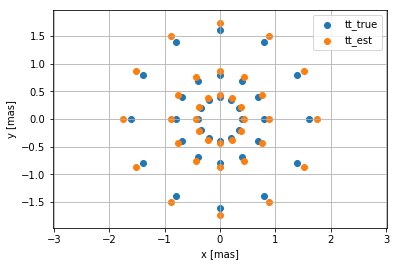

In [10]:
conf, psf, psfs, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case, ls_misalign=[0, 1])
_, tt_true, tt_est = plot_point_err(conf, psf, psfs, tt_lamD, qacits_params=circ_params);
plot_circ_drift(tt_true, tt_est)

# 2) Full M1 pupil


In [11]:
pupil_shape = 'fullM1'

## 2.1) L-band CVC

In [12]:
band = 'L'
mode = 'CVC'
ls_params = [0.0291, 0.08, 0.0317]

### Calibration: x,y pointing drift -> 1 lambda/D

In [13]:
case = 'calib'


Case = calib
Loading PSFs

Model calibration results:
Inner slope = 0.229
Outer slope = 0.122
Full coeff  = 3.484
rms = 0.453 mas


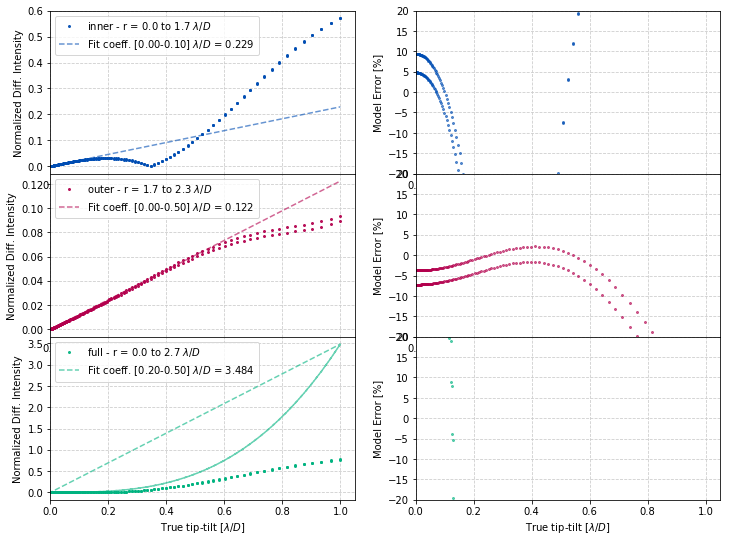

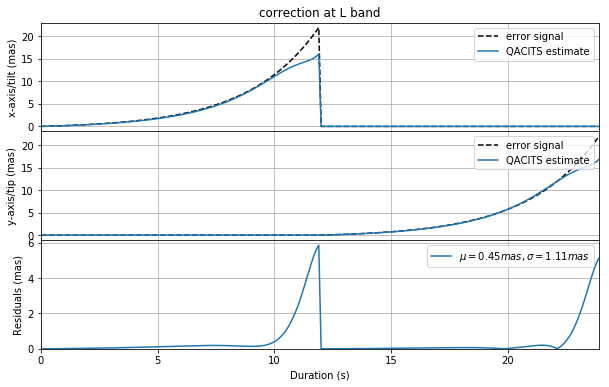

In [14]:
conf, psf, psfs, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case)
L_CVC_params, _, _ = plot_point_err(conf, psf, psfs, tt_lamD)

### Circular drift

In [15]:
case = 'circ_drift'


Case = circ_drift_[1.6, 0.8, 0.4]
Loading PSFs
rms = 0.047 mas


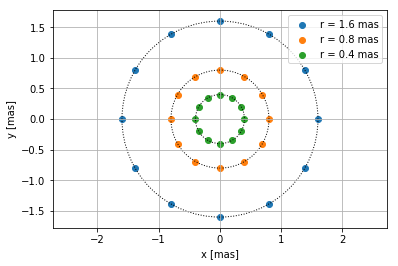

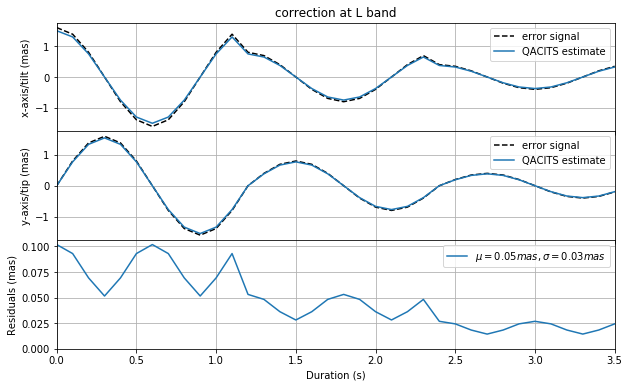

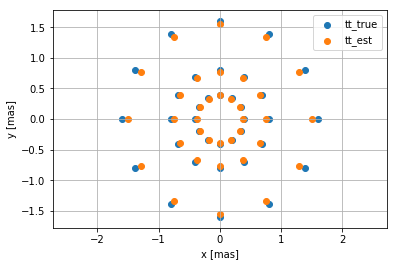

In [16]:
conf, psf, psfs, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case)
_, tt_true, tt_est = plot_point_err(conf, psf, psfs, tt_lamD, qacits_params=L_CVC_params);
plot_circ_drift(tt_true, tt_est)

### X-axis LS misalignment (1%)


Case = circ_drift_[1.6, 0.8, 0.4]_misalign_[1, 0]
Loading PSFs
rms = 0.047 mas


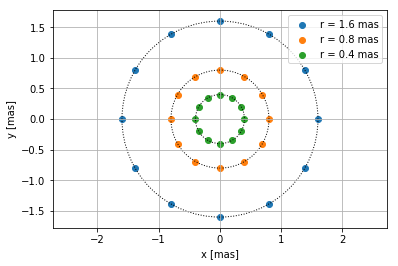

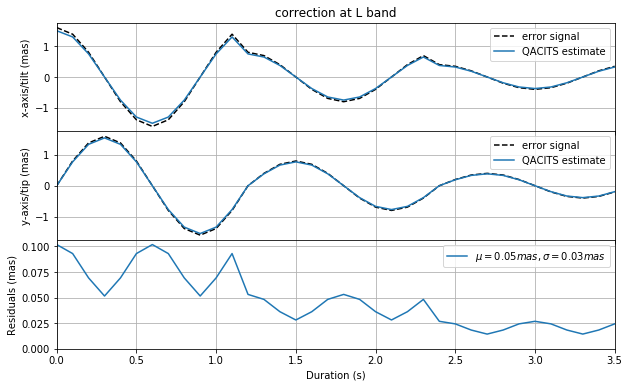

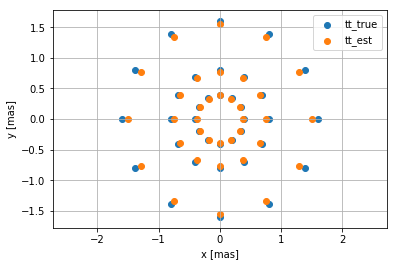

In [17]:
conf, psf, psfs, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case, ls_misalign=[1, 0])
_, tt_true, tt_est = plot_point_err(conf, psf, psfs, tt_lamD, qacits_params=L_CVC_params);
plot_circ_drift(tt_true, tt_est)

### Y-axis LS misalignment (1%)


Case = circ_drift_[1.6, 0.8, 0.4]_misalign_[0, 1]
Loading PSFs
rms = 0.047 mas


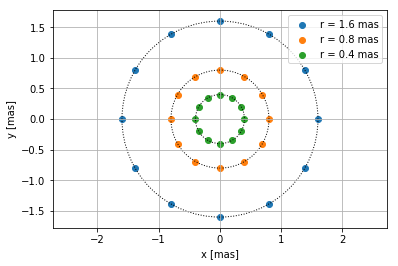

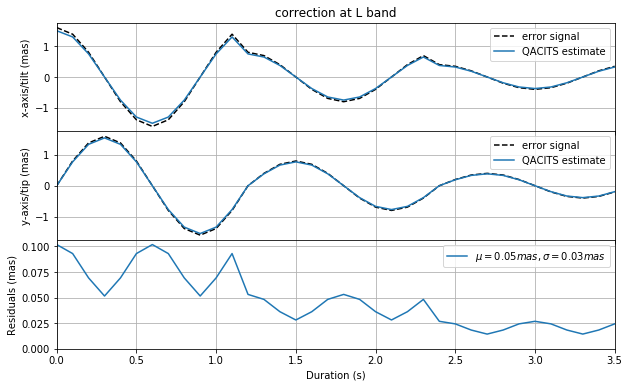

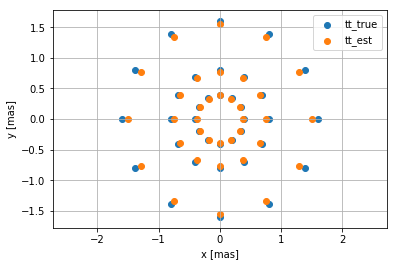

In [18]:
conf, psf, psfs, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case, ls_misalign=[0, 1])
_, tt_true, tt_est = plot_point_err(conf, psf, psfs, tt_lamD, qacits_params=L_CVC_params);
plot_circ_drift(tt_true, tt_est)

### SCAO + random pointing drift (quasistatics = 0.4 mas rms ; jitter = 2 mas rms)

In [19]:
case = 'scao+random_drift'


Case = scao+random_drift
Loading PSFs
rms = 0.384 mas


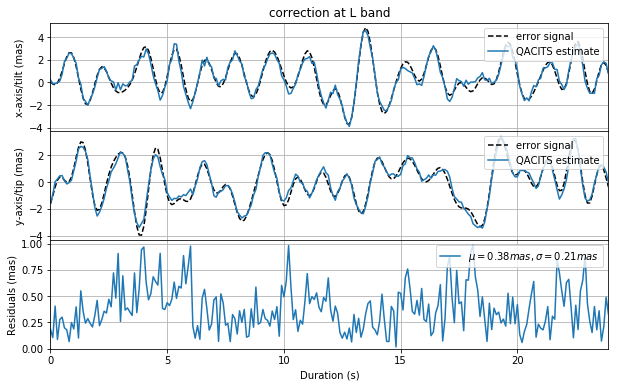

In [20]:
conf, psf, psfs, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case)
plot_point_err(conf, psf, psfs, tt_lamD, qacits_params=L_CVC_params);

Loading RMS array


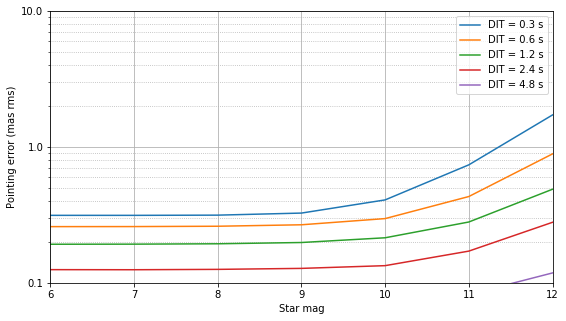

In [21]:
rms_arr = rms_mag(L_CVC_params, conf, psf, psfs, tt_lamD, rmags[band])
plot_rms_mag(rms_arr, rmags[band])

## with astigmatism


Case = scao+random_drift_astigmatism_3.00e-08
Loading PSFs
rms = 0.407 mas
Loading RMS array


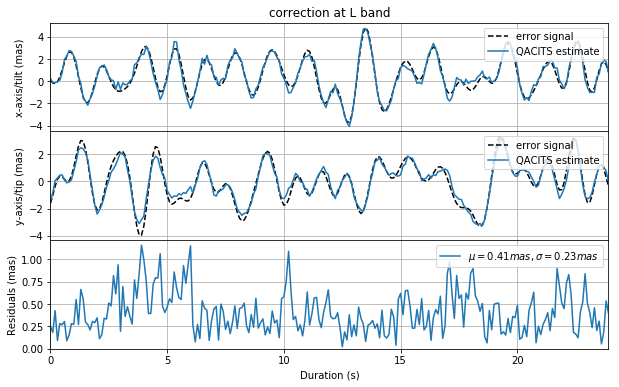

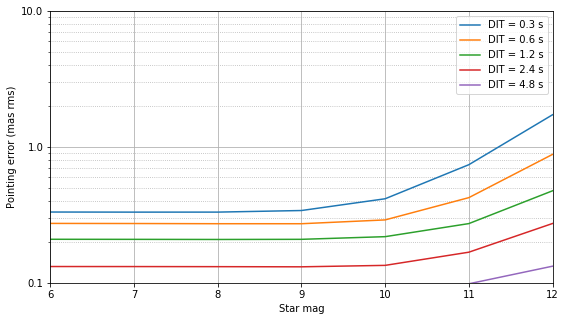

In [22]:
astigmatism = 30e-9
conf, psf, psfs, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case, astigmatism=astigmatism)
plot_point_err(conf, psf, psfs, tt_lamD, qacits_params=L_CVC_params, show_fig=True);
rms_arr = rms_mag(L_CVC_params, conf, psf, psfs, tt_lamD, rmags[band])
plot_rms_mag(rms_arr, rmags[band])


Case = scao+random_drift_astigmatism_4.00e-08
Loading PSFs
rms = 0.425 mas
Loading RMS array


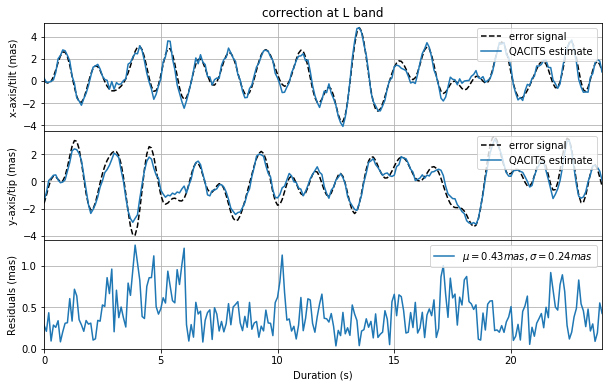

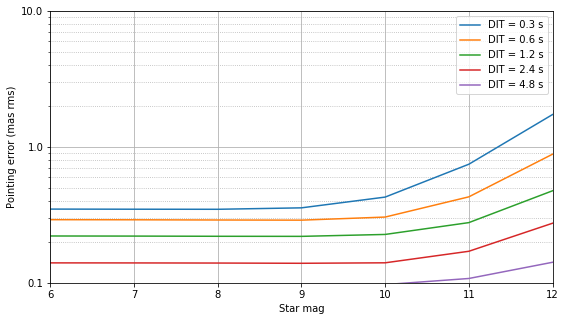

In [23]:
astigmatism = 40e-9
conf, psf, psfs, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case, astigmatism=astigmatism)
plot_point_err(conf, psf, psfs, tt_lamD, qacits_params=L_CVC_params, show_fig=True);
rms_arr = rms_mag(L_CVC_params, conf, psf, psfs, tt_lamD, rmags[band])
plot_rms_mag(rms_arr, rmags[band])


Case = scao+random_drift_astigmatism_5.00e-08
Loading PSFs
rms = 0.447 mas
Loading RMS array


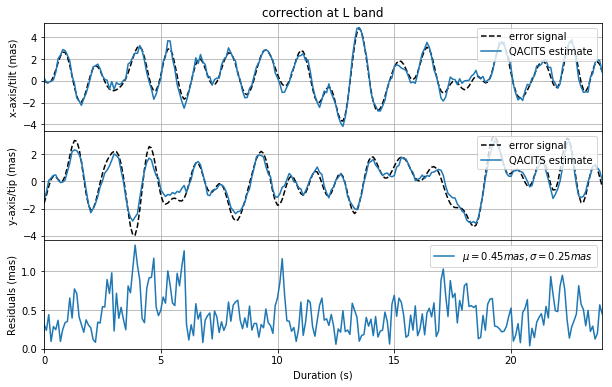

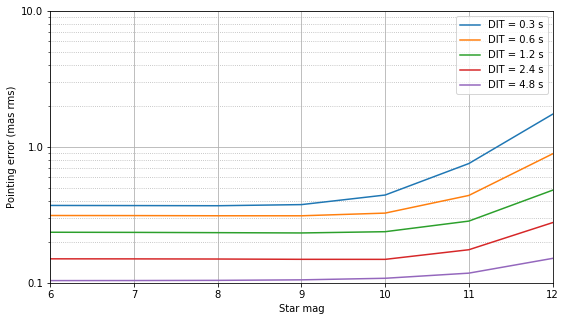

In [24]:
astigmatism = 50e-9
conf, psf, psfs, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case, astigmatism=astigmatism)
plot_point_err(conf, psf, psfs, tt_lamD, qacits_params=L_CVC_params, show_fig=True);
rms_arr = rms_mag(L_CVC_params, conf, psf, psfs, tt_lamD, rmags[band])
plot_rms_mag(rms_arr, rmags[band])


Case = scao+random_drift_astigmatism_6.00e-08
Loading PSFs
rms = 0.472 mas
Loading RMS array


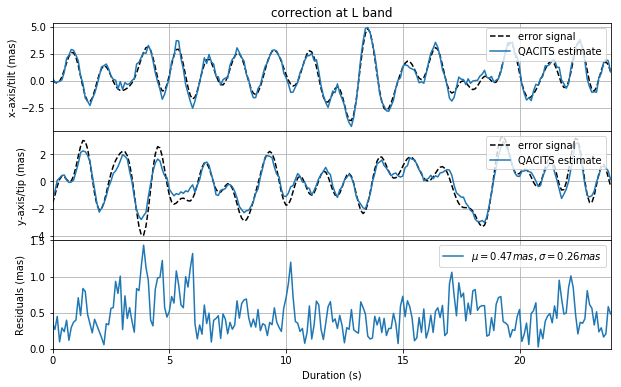

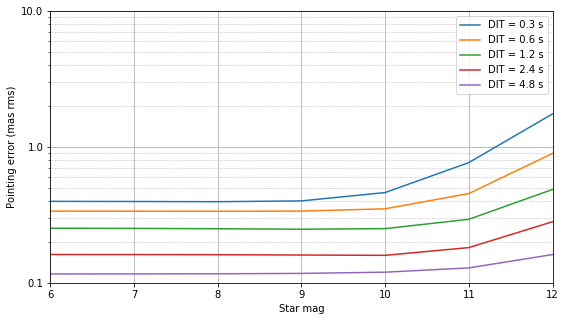

In [25]:
astigmatism = 60e-9
conf, psf, psfs, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case, astigmatism=astigmatism)
plot_point_err(conf, psf, psfs, tt_lamD, qacits_params=L_CVC_params, show_fig=True);
rms_arr = rms_mag(L_CVC_params, conf, psf, psfs, tt_lamD, rmags[band])
plot_rms_mag(rms_arr, rmags[band])

## 2.2) N-band CVC

In [26]:
band = 'N2'
mode = 'CVC'
ls_params = [0.0356, 0.08, 0.0383]

### Calibration: x,y pointing drift -> lambda/D

In [27]:
case = 'calib'


Case = calib
Loading PSFs

Model calibration results:
Inner slope = 0.233
Outer slope = 0.125
Full coeff  = 3.656
rms = 1.504 mas


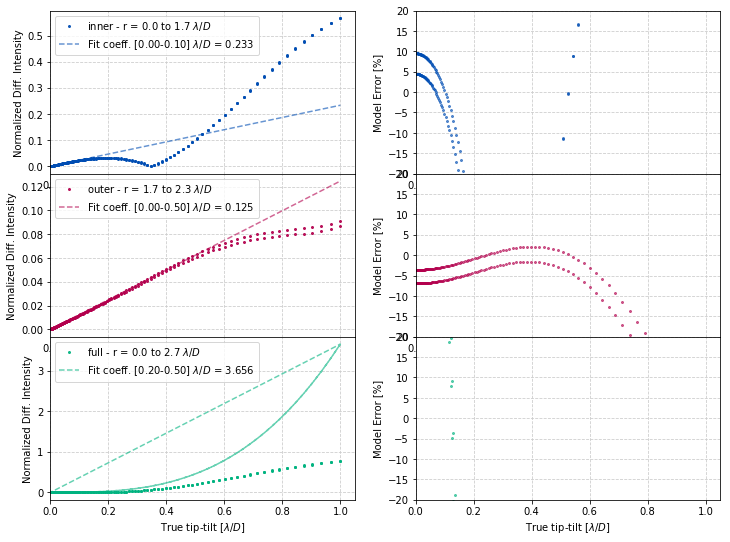

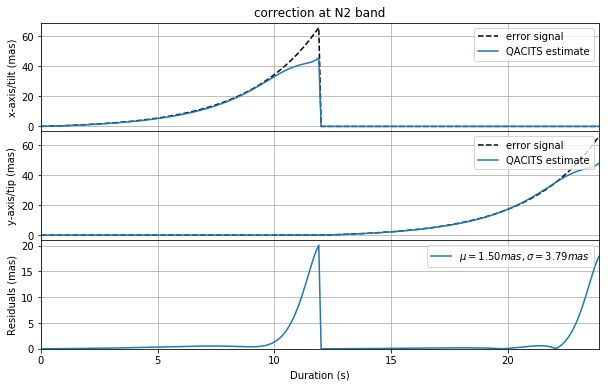

In [28]:
conf, psf, psfs, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case)
N_CVC_params, _, _ = plot_point_err(conf, psf, psfs, tt_lamD)

### SCAO + random pointing drift (3 times L-band)

In [29]:
case = 'scao+random_drift'


Case = scao+random_drift
Loading PSFs
rms = 0.441 mas


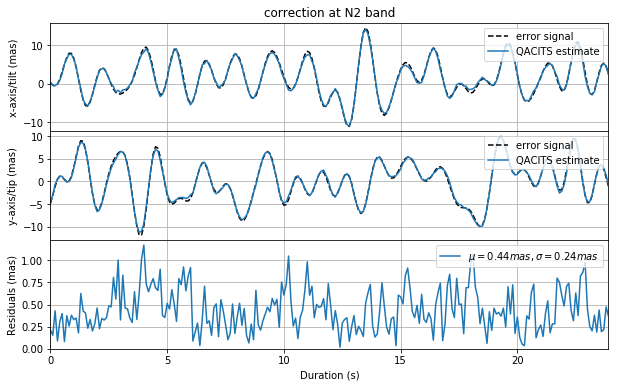

In [30]:
conf, psf, psfs, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case)
plot_point_err(conf, psf, psfs, tt_lamD, qacits_params=N_CVC_params);

Loading RMS array


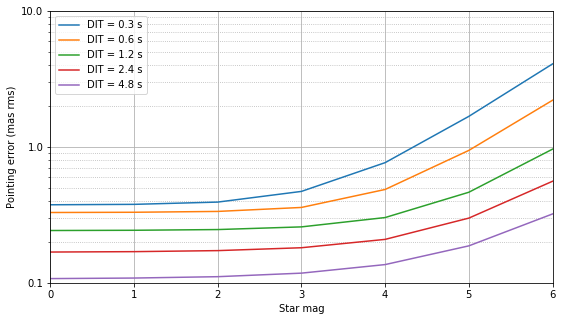

In [31]:
rms_arr = rms_mag(N_CVC_params, conf, psf, psfs, tt_lamD, rmags[band])
plot_rms_mag(rms_arr, rmags[band])

## with astigmatism


Case = scao+random_drift_astigmatism_9.00e-08
Loading PSFs
rms = 0.545 mas
Loading RMS array


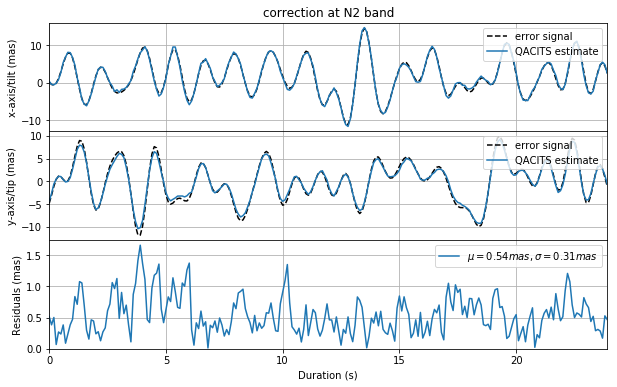

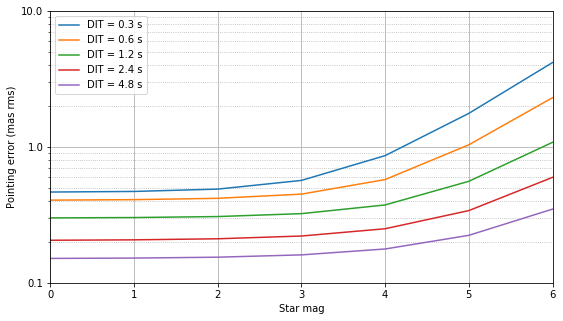

In [32]:
astigmatism = 3*30e-9
conf, psf, psfs, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case, astigmatism=astigmatism)
plot_point_err(conf, psf, psfs, tt_lamD, qacits_params=N_CVC_params, show_fig=True);
rms_arr = rms_mag(N_CVC_params, conf, psf, psfs, tt_lamD, rmags[band])
plot_rms_mag(rms_arr, rmags[band])


Case = scao+random_drift_astigmatism_1.20e-07
Loading PSFs
rms = 0.636 mas
Loading RMS array


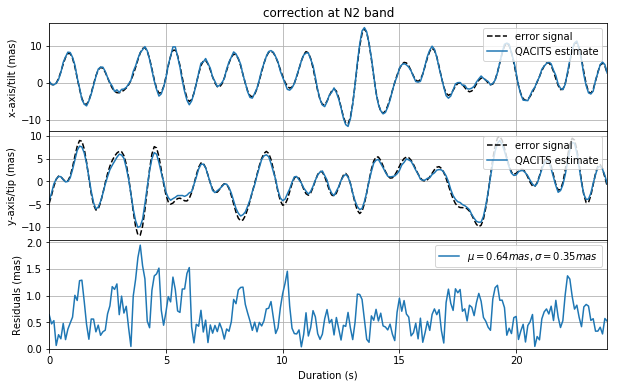

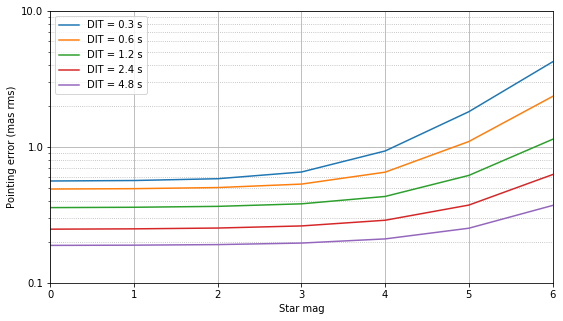

In [33]:
astigmatism = 3*40e-9
conf, psf, psfs, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case, astigmatism=astigmatism)
plot_point_err(conf, psf, psfs, tt_lamD, qacits_params=N_CVC_params, show_fig=True);
rms_arr = rms_mag(N_CVC_params, conf, psf, psfs, tt_lamD, rmags[band])
plot_rms_mag(rms_arr, rmags[band])


Case = scao+random_drift_astigmatism_1.50e-07
Loading PSFs
rms = 0.741 mas
Loading RMS array


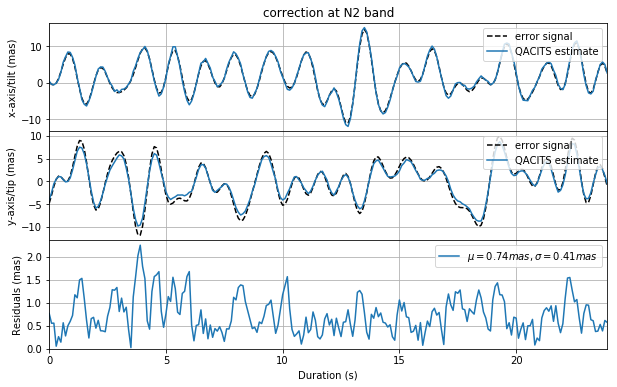

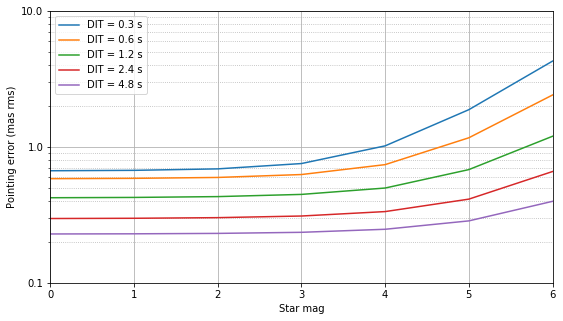

In [34]:
astigmatism = 3*50e-9
conf, psf, psfs, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case, astigmatism=astigmatism)
plot_point_err(conf, psf, psfs, tt_lamD, qacits_params=N_CVC_params, show_fig=True);
rms_arr = rms_mag(N_CVC_params, conf, psf, psfs, tt_lamD, rmags[band])
plot_rms_mag(rms_arr, rmags[band])


Case = scao+random_drift_astigmatism_1.80e-07
Loading PSFs
rms = 0.855 mas
Loading RMS array


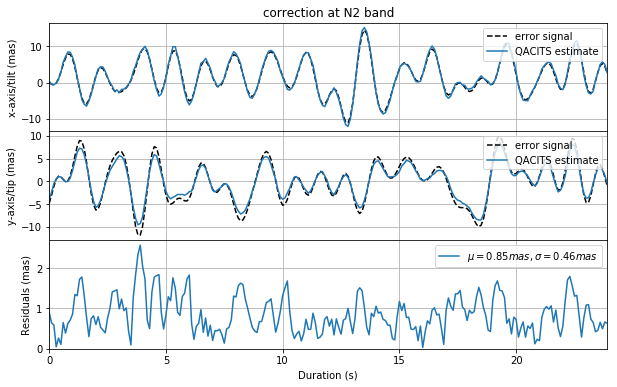

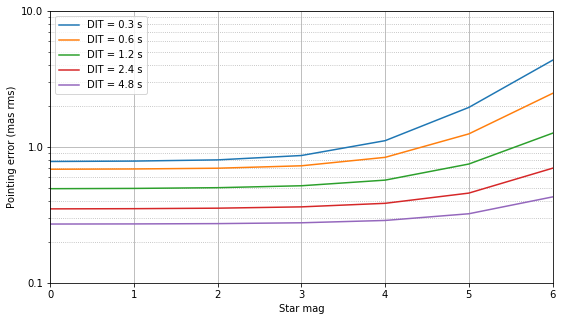

In [35]:
astigmatism = 3*60e-9
conf, psf, psfs, tt_lamD = create_psfs(band, mode, ls_params, pupil_shape, case, astigmatism=astigmatism)
plot_point_err(conf, psf, psfs, tt_lamD, qacits_params=N_CVC_params, show_fig=True);
rms_arr = rms_mag(N_CVC_params, conf, psf, psfs, tt_lamD, rmags[band])
plot_rms_mag(rms_arr, rmags[band])